In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web 
import matplotlib.pyplot as plt
import scipy.optimize as sco 
import quandl
import random

In [2]:
# I construct a dataframe with the prices(adjusted close price) of the Goldmand Sach Group, The Banck of America, Key Corp, and 
# Disney. 

symbols = ['WIKI/AXP','WIKI/NBL','WIKI/YHOO', 'WIKI/MSFT']
noa = len(symbols)

df = pd.DataFrame({'Symbol': {'WIKI/GS': 'The Goldman Sachs Group(GSH)',
                                        'WIKI/BAC': 'Bank of America(BAC)',
                                        'WIKI/KEY': 'Key Corp(KEY)',
                                        'WIKI/DIS': 'Disney(DIS)'}})

In [3]:
df["Symbol"] = df.Symbol.map(lambda x: x[-4:-1])
# With the .10 parameter, we obtain the adjusted close price of the stock
prices = [quandl.get("{0}.10".format(sym), start_date="2015-01-03", end_date="2017-06-30") for sym in df.index]
df_prices = pd.concat(prices,axis=1)
df_prices.columns = [sym for sym in df.Symbol]
df_prices = df_prices.fillna(method="ffill")

In [4]:
df_prices.tail()

,BAC,DIS,GSH,KEY
Date,,,,
2017-06-26,22.730,103.776779,217.6963,17.8600
2017-06-27,23.000,104.352434,219.5600,18.2000
2017-06-28,23.529,103.737079,220.7500,18.3200
2017-06-29,24.035,104.541011,223.0300,18.5200
2017-06-30,24.170,104.709738,221.5400,18.5534


Means_return:
 BAC    0.148148
DIS    0.066769
GSH    0.080936
KEY    0.152585
dtype: float64
Covariance Matrix:
           BAC       DIS       GSH       KEY
BAC  0.078503  0.026699  0.054876  0.062790
DIS  0.026699  0.038693  0.023491  0.021506
GSH  0.054876  0.023491  0.056268  0.047914
KEY  0.062790  0.021506  0.047914  0.069523


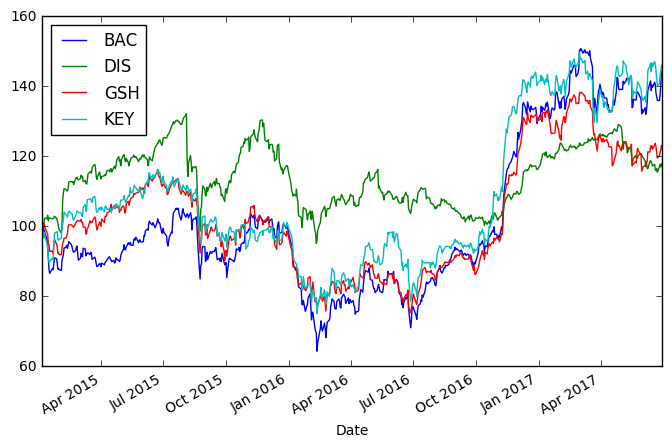

In [5]:

rets = np.log(df_prices / df_prices.shift(1))
print("Means_return:\n", 
      rets.mean() * 252)

print("Covariance Matrix:\n", 
      rets.cov() * 252) 
# Normalize and plot the time series of each of the stocks
(df_prices / df_prices.ix[0] * 100).plot(figsize=(8, 5))
plt.show()

In [6]:
# Generate an array of the weights of the portfolio with the numpy random function
weights = np.random.random(noa)
weights /= np.sum(weights)


In [7]:
rp = np.sum(rets.mean() * weights) * 252 ## Expected Portfolio Return 
op = np.dot(weights.T, np.dot(rets.cov() * 252, weights))  ## Expected Portfolio Variance 

## Expected Portfolio standard deviation/volatility
sd = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

print("Portfolio Return:\n",
     round(rp,3))
print("Portfolio Variance:\n",
     round(op,3))
print("Portfolio Standard Deviation:\n",
     round(sd,3))


Portfolio Return:
 0.096
Portfolio Variance:
 0.038
Portfolio Standard Deviation:
 0.196


In [8]:
# Run a Monte Carlo simulation to obtain differents sets of risk and returns by varying the weights of the portfolio
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa) ## Simulated allocations
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,
    np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)


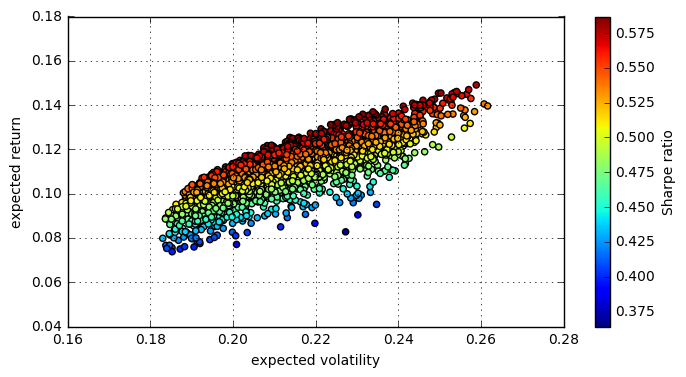

In [9]:
## Plot the results and show the sharpe ratio with the c parameter
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [10]:

## Porfolio Optimization 
# I will optimize the portfolio by looking for the weights that yields the maximum sharpe ratio between many portfolios
# The function statistics receive the weights parameter and return an array the with the portfolio value, portfolio volatility,
# and the sharpe ratio of the portfolio

def statistics(weights):
    ''' Return portfolio statistics.
    Parameters
    ==========
    Weights: array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected porfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0 
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) *252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret/pvol])

In [11]:
# Formally, we minimize the negative value of the Sharpe ratio    
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [12]:
# equality constrain of the sum of the weights of the portfolio equal to 1 
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
# bounds the parameter values for x to be within zero and one 
bnds = tuple((0,1) for x in range(noa))

# initial guesses for the weights 
noa * [1./ noa,]
 
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP', 
                    bounds = bnds, constraints= cons)

print("Weights Optimization:", opts['x'].round(3))
print("Mean, Volatility and Sharpe Ratio of optimal portfolio:", statistics(opts['x']).round(3))

Weights Optimization: [ 0.112  0.21   0.     0.679]
Mean, Volatility and Sharpe Ratio of optimal portfolio: [ 0.134  0.227  0.59 ]


The portfolio with the maximum sharpe ratio has a mean of returns of 13.4% and a volatility of 22.7%. The optimal weights for the portfolio are stores in the opts list where we can see the different allocations for the stocks that
compose the portfolio. 

In [13]:
# Minimize the variance of the portfolio 
def min_func_variance(weights):
    return statistics(weights)[1] ** 2 ## variance

In [14]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method= 'SLSQP', bounds= bnds,
                    constraints= cons)
optv['x'].round(3)
statistics(optv['x']).round(3)



print("Weights Optimization:", optv['x'].round(3))
print("Mean, Volatility and Sharpe Ratio of optimal portfolio:", statistics(optv['x']).round(3))

Weights Optimization: [ 0.     0.665  0.216  0.119]
Mean, Volatility and Sharpe Ratio of optimal portfolio: [ 0.08   0.183  0.439]


In the above cell, I found the portfolio with the minimun variance tha  has a return of 8% and a volatility of 18,3%. 

In [15]:
## Efficient Frontier
# The approach is that we fix a target return level and derive for each such level those portfolio weights that
# lead to the minimum volatility value.

cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
         {'type': 'eq', 'fun': lambda x: np.sum(x) -1})
bnds = tuple((0,1) for x in weights)

def min_func_port(weights):
    return statistics(weights)[1]

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x : statistics(x)[0] - tret},
             {'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method= 'SLSQP',
                       bounds = bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)



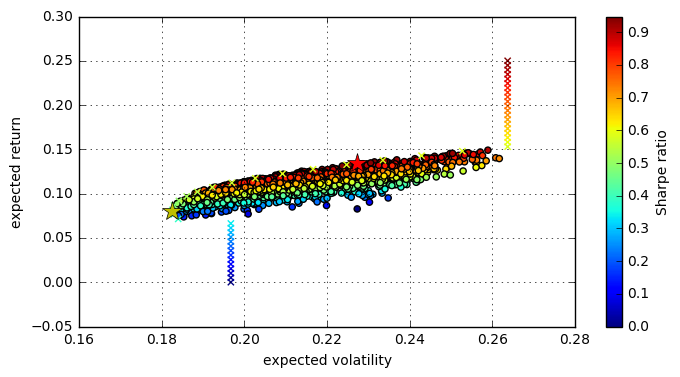

In [16]:
plt.figure(figsize=(8,4))
#random portfolio composition
plt.scatter(pvols, prets, c= prets/pvols, marker='o')
# efficient frontier
plt.scatter(tvols, trets, c=trets/ tvols, marker='x')
# Portfolio with highest Sharpe ratio. In the x axis, is situated the volatility of the portfolio,
# and in the y axis are the returns .  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
       'r*', markersize =15.0)
# Minimum variance portfolio. x= varianza del portafolio con minima varianza, y= retorno del portafolio
# con minima varianza 
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In this graph we can view the portfolio with the maximum ratio of sharpe that is showed with a big red start, and the portfolio of minimum variance that is showed with a big yellow start. The crosses in yellow color conform the efficient frontier of the portfolios and the rest of the points are others portfolios, generated at random to better visualize the efficient frontier.  